# Data Collection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd

import matplotlib as mpl
import matplotlib


os.chdir(".")
res1 = [i for i in glob.glob("results/MAP_dataset=*[!fixed_prior]")]
df = []
for f in res1:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
MAP = pd.concat(df)


res1 = [i for i in glob.glob("results/LLA_dataset=*[!fixed_prior]")]
df = []
for f in res1:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
LLA = pd.concat(df)


res1 = [i for i in glob.glob("results/ELLA_dataset=*[!fixed_prior]")]
df = []
for f in res1:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
ELLA = pd.concat(df)


In [2]:

min_value = ELLA.groupby(["M", "dataset", "seed"])["val_NLL"].min()
ELLA_min = ELLA.merge(min_value, on=["M", "dataset", "seed"], suffixes=('', '_min'))
ELLA_min = ELLA_min.query("val_NLL == val_NLL_min")
#print(indices_min_nll)
#ELLA_max = ELLA.loc[indices_min_nll]
ELLA_min = ELLA_min.groupby(["M", "dataset", "seed"]).first().reset_index()
ELLA_min = ELLA_min.drop("val_NLL_min", axis = 1)

In [3]:


res1 = [i for i in glob.glob("results/VaLLA_dataset*[!fixed_prior]")]
df = []
for f in res1:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
VaLLA = pd.concat(df)


def std(x):
    return np.std(x) / np.sqrt(len(x))


VaLLA["model"] = "VaLLA"
MAP["model"] = "MAP"
ELLA_min["model"] = "ELLA"
LLA["model"] = "LLA"

df = pd.concat([MAP, LLA, ELLA_min, VaLLA]).drop(
    ["LOSS", "Unnamed: 0", "iterations", "weight_decay", "MAP_iterations"], axis=1
)


/tmp/ipykernel_11105/1351975395.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  MAP["model"] = "MAP"


In [4]:
regression = df[df["dataset"].isin(["Year", "Airline", "Taxi"])]
multiclass = df[~df["dataset"].isin(["Year", "Airline", "Taxi"])]
regression = regression.dropna(axis = 1, how = 'all')
multiclass = multiclass.dropna(axis = 1, how = 'all')

In [5]:
Q = np.array([np.zeros_like(np.abs(regression["Q-10"]-0.1)), 
              np.abs(regression["Q-10"]-0.1).to_numpy(), 
              np.abs(regression["Q-20"]-0.2).to_numpy(), 
              np.abs(regression["Q-30"]-0.3).to_numpy(), 
              np.abs(regression["Q-40"]-0.4).to_numpy(), 
              np.abs(regression["Q-50"]-0.5).to_numpy(), 
              np.abs(regression["Q-60"]-0.6).to_numpy(), 
              np.abs(regression["Q-70"]-0.7).to_numpy(), 
              np.abs(regression["Q-80"]-0.8).to_numpy(), 
              np.abs(regression["Q-90"]-0.9).to_numpy(),
              np.ones_like(np.abs(regression["Q-10"]-0.1))
              ]).T

In [6]:
import scipy as sp
Q = sp.integrate.trapezoid(x = np.arange(0, 1.1, 0.1), y= Q, axis = 1)
regression["Q"] = Q

In [7]:

# df = df.astype({"M": "int"})
regression = regression.groupby(["dataset", "model","M", "subset", "hessian"], dropna=False).agg(["mean", std])
regression = regression.drop(["seed", "val_NLL", "log_variance", "alpha"], axis = 1)
regression = regression.drop(("RMSE", "std"),axis = 1)
regression = regression.dropna(axis = 1, how = 'all')

In [8]:
multiclass_orig = multiclass

In [9]:
multiclass = multiclass.groupby(["dataset", "model","M", "subset", "hessian", "alpha"], dropna=False).agg(["mean", std])
multiclass = multiclass.drop(["seed", "val_NLL"], axis = 1)
multiclass = multiclass.dropna(axis = 1, how = 'all')

# Regression Fully Connected 200-200-200

## Trainable / Validated Prior

#### Airline

In [10]:
subset =  [("RMSE", "mean"), ("NLL", "mean"),
           ("CRPS", "mean"), ("Q", "mean"),]

Q_columns = ["Q-10", "Q-20", "Q-30", "Q-40", "Q-50", "Q-60", "Q-70", "Q-80", "Q-90"]
regression.query("dataset == 'Airline'").drop(Q_columns, axis = 1).reset_index().style.background_gradient(axis=0, subset = subset) 

In [11]:
pd.set_option("display.precision", 3)
regression.query("dataset == 'Airline'")[subset].reset_index()

,dataset,model,M,subset,hessian,RMSE,NLL,CRPS,Q
,,,,,,mean,mean,mean,mean
0,Airline,ELLA,2000.0,NaN,NaN,38.903,5.086,18.437,0.158
1,Airline,LLA,NaN,all,diag,38.903,5.097,18.319,0.145
2,Airline,LLA,NaN,all,kron,38.903,5.097,18.317,0.145
3,Airline,LLA,NaN,last_layer,diag,38.903,5.097,18.317,0.145
4,Airline,LLA,NaN,last_layer,full,38.903,5.097,18.317,0.145
5,Airline,LLA,NaN,last_layer,kron,38.903,5.097,18.317,0.145
6,Airline,MAP,NaN,NaN,NaN,38.903,5.087,18.436,0.158
7,Airline,VaLLA,100.0,NaN,NaN,38.903,4.923,18.610,0.109
8,Airline,VaLLA,200.0,NaN,NaN,38.903,4.918,18.615,0.107


In [12]:

def get_Q_plot_queries(dataset):
    return [
        #"dataset == '"+dataset+"' and model == 'MAP'",
        "dataset == '"+dataset+"' and model == 'ELLA'",
        "dataset == '"+dataset+"' and model == 'VaLLA' and M == 100",
        #"dataset == '"+dataset+"' and model == 'VaLLA' and M == 200",
        "dataset == '"+dataset+"' and model == 'LLA' and hessian == 'kron' and subset == 'all'",
        #"dataset == '"+dataset+"' and model == 'LLA' and hessian == 'diag' and subset == 'all'",
        #"dataset == '"+dataset+"' and model == 'LLA' and hessian == 'full' and subset == 'last_layer'"
    ]

Q_plot_labels = ["ELLA", "VaLLA", "LLA KFAC", "LLA Diag", r"LLA$^\star$"]
Q_plot_markes = [">", "<", "^", "v", "*", "o"]
Q_plot_linestyles = ["-", ":", "-", "-.", "--", ":", "--"]
columns = [('Q-10', 'mean'),
 ('Q-20', 'mean'),
 ('Q-30', 'mean'),
 ('Q-40', 'mean'),
 ('Q-50', 'mean'),
 ('Q-60', 'mean'),
 ('Q-70', 'mean'),
 ('Q-80', 'mean'),
 ('Q-90', 'mean')]


In [13]:
import matplotlib as mpl
import matplotlib
mpl.rcParams.update(mpl.rcParamsDefault)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = (16, 9)
fontsize = 32
matplotlib.rcParams.update({'font.size': fontsize})
jet = plt.colormaps["Dark2"]
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})
def Q_plot(dataset, axis):
    axis.xaxis.set_tick_params(labelsize=24)
    axis.yaxis.set_tick_params(labelsize=24)
    Q_queries_plot = get_Q_plot_queries(dataset)
    x = np.linspace(0, 1, 11)
    for i in range(len(Q_queries_plot)):
        axis.plot(x, [0, *regression.query(Q_queries_plot[i]).reset_index()[columns].to_numpy().flatten(), 1],
            label = Q_plot_labels[i], color = jet(i), lw = 4)

    axis.plot(x, x, color = "black",  lw = 3)
    axis.set_xlabel(r"$\alpha$")
    axis.set_ylabel(r"$\mathbb{P}_{(\mathbf{x}, y)}[y \in I(\mathbf{x}, \alpha)]$")

### Year

In [14]:
regression.query("dataset == 'Year'").drop(Q_columns, axis = 1).reset_index().style.background_gradient(axis=0, subset = subset) 

In [15]:
regression.query("dataset == 'Year'")[subset].reset_index()

,dataset,model,M,subset,hessian,RMSE,NLL,CRPS,Q
,,,,,,mean,mean,mean,mean
0,Year,ELLA,2000.0,NaN,NaN,9.317,3.674,5.056,0.164
1,Year,LLA,NaN,all,diag,9.317,3.650,4.957,0.122
2,Year,LLA,NaN,all,kron,9.317,3.650,4.955,0.121
3,Year,LLA,NaN,last_layer,diag,9.317,3.651,4.954,0.120
4,Year,LLA,NaN,last_layer,full,9.317,3.651,4.954,0.120
5,Year,LLA,NaN,last_layer,kron,9.317,3.651,4.954,0.120
6,Year,MAP,NaN,NaN,NaN,9.317,3.674,5.056,0.164
7,Year,VaLLA,100.0,NaN,NaN,9.317,3.527,5.071,0.084
8,Year,VaLLA,200.0,NaN,NaN,9.317,3.493,5.026,0.076


### Taxi

In [16]:
regression.query("dataset == 'Taxi'").drop(Q_columns, axis = 1).reset_index().style.background_gradient(axis=0, subset = subset) 

In [17]:
regression.query("dataset == 'Taxi'")[subset].reset_index()

,dataset,model,M,subset,hessian,RMSE,NLL,CRPS,Q
,,,,,,mean,mean,mean,mean
0,Taxi,ELLA,2000.0,NaN,NaN,9.969,3.753,3.754,0.227
1,Taxi,LLA,NaN,all,diag,9.969,3.714,3.979,0.270
2,Taxi,LLA,NaN,all,kron,9.969,3.705,3.977,0.270
3,Taxi,LLA,NaN,last_layer,diag,9.969,3.718,3.976,0.270
4,Taxi,LLA,NaN,last_layer,full,9.969,3.718,3.976,0.270
5,Taxi,LLA,NaN,last_layer,kron,9.969,3.718,3.976,0.270
6,Taxi,MAP,NaN,NaN,NaN,9.969,3.763,3.753,0.227
7,Taxi,VaLLA,100.0,NaN,NaN,9.969,3.287,3.968,0.188
8,Taxi,VaLLA,200.0,NaN,NaN,9.969,3.280,3.993,0.188


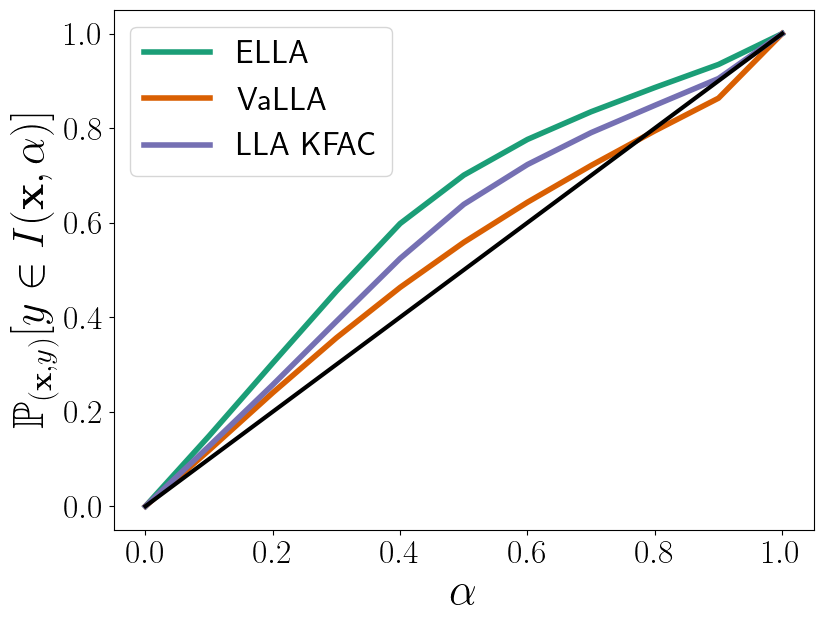

In [18]:
fig, axis = plt.subplots(1, 1, figsize=(9, 7))
Q_plot("Year", axis)
plt.legend(fontsize = 24)
fig.tight_layout()
plt.savefig("Q_Year_plot.pdf", format = "pdf", bbox_inches='tight')
plt.show()

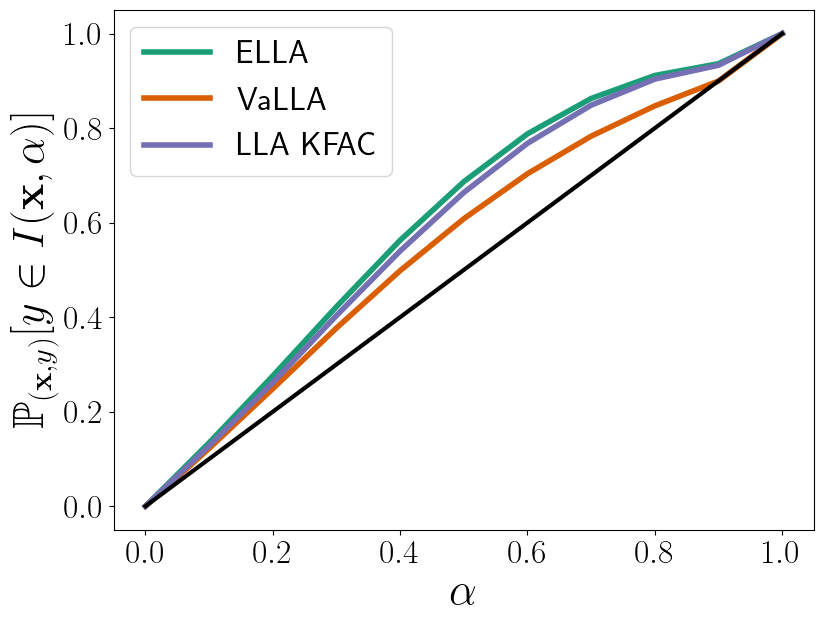

In [19]:
fig, axis = plt.subplots(1, 1, figsize=(9, 7))
Q_plot("Airline", axis)
plt.legend(fontsize = 24)
fig.tight_layout()
plt.savefig("Q_Airline_plot.pdf", format = "pdf", bbox_inches='tight')
plt.show()

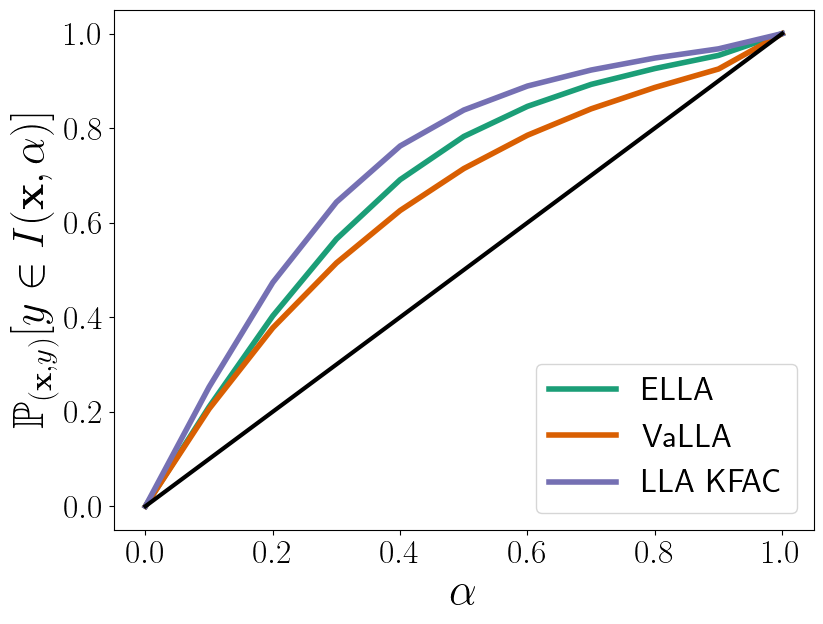

In [20]:
fig, axis = plt.subplots(1, 1, figsize=(9, 7))
Q_plot("Taxi", axis)
plt.legend(fontsize = 24)
fig.tight_layout()
plt.savefig("Q_Taxi_plot.pdf", format = "pdf", bbox_inches='tight')
plt.show()

# Classification Fully-Connected 200-200

### Trainable/Validated Prior

In [21]:
multiclass

NLL                  time  \
                                                mean        std       mean   
dataset model M      subset     hessian alpha                                
FMNIST  ELLA  2000.0 NaN        NaN     NaN    0.373  6.245e-06   1337.935   
        LLA   NaN    all        diag    NaN    0.397  1.546e-07    315.173   
                                kron    NaN    0.377  0.000e+00    250.853   
                     last_layer diag    NaN    0.374  0.000e+00     42.627   
                                full    NaN    0.373  0.000e+00  46567.896   
                                kron    NaN    0.373  0.000e+00     48.783   
        MAP   NaN    NaN        NaN     NaN    0.373  0.000e+00      0.000   
        VaLLA 100.0  NaN        NaN     1.0    0.355  2.093e-05   2244.138   
              200.0  NaN        NaN     1.0    0.352  4.534e-05   3627.251   
              500.0  NaN        NaN     1.0    0.349  3.855e-05   9130.125   
MNIST   ELLA  2000.0 NaN        NaN     NaN    0.076  2.584e-08   1654.155   
        LLA   NaN    all        diag    NaN    0.143  6.158e-07    326.551   
                                kron    NaN    0.094  0.000e+00    985.222   
                     last_layer diag    NaN    0.080  0.000e+00     47.798   
                                full    NaN    0.081  6.931e-08  33590.535   
                                kron    NaN    0.081  0.000e+00     51.632   
        MAP   NaN    NaN        NaN     NaN    0.076  0.000e+00      0.000   
        VaLLA 100.0  NaN        NaN     1.0    0.076  3.557e-06   3170.863   
              200.0  NaN        NaN     1.0    0.075  8.700e-06   4041.698   
              500.0  NaN        NaN     1.0    0.075  3.468e-06  10804.546   

                                                           ACC             \
                                                    std   mean        std   
dataset model M      subset     hessian alpha                               
FMNIST  ELLA  2000.0 NaN        NaN     NaN     153.925  0.866  3.345e-05   
        LLA   NaN    all        diag    NaN     103.525  0.862  0.000e+00   
                                kron    NaN       0.000  0.865  0.000e+00   
                     last_layer diag    NaN       0.340  0.865  0.000e+00   
                                full    NaN    6362.705  0.866  0.000e+00   
                                kron    NaN       5.502  0.866  0.000e+00   
        MAP   NaN    NaN        NaN     NaN       0.000  0.866  0.000e+00   
        VaLLA 100.0  NaN        NaN     1.0      36.568  0.874  4.558e-05   
              200.0  NaN        NaN     1.0     164.838  0.876  1.757e-04   
              500.0  NaN        NaN     1.0     366.401  0.877  9.547e-05   
MNIST   ELLA  2000.0 NaN        NaN     NaN     276.865  0.976  4.965e-17   
        LLA   NaN    all        diag    NaN     119.274  0.974  0.000e+00   
                                kron    NaN      97.751  0.975  4.965e-17   
                     last_layer diag    NaN       6.882  0.976  4.965e-17   
                                full    NaN    3829.575  0.976  4.965e-17   
                                kron    NaN       3.123  0.976  0.000e+00   
        MAP   NaN    NaN        NaN     NaN       0.000  0.976  0.000e+00   
        VaLLA 100.0  NaN        NaN     1.0     963.566  0.977  2.828e-05   
              200.0  NaN        NaN     1.0     130.235  0.977  3.347e-05   
              500.0  NaN        NaN     1.0      83.842  0.977  5.214e-05   

                                                 ECE             BRIER  \
                                                mean        std   mean   
dataset model M      subset     hessian alpha                            
FMNIST  ELLA  2000.0 NaN        NaN     NaN    0.008  5.495e-05  0.193   
        LLA   NaN    all        diag    NaN    0.043  2.013e-07  0.201   
                                kron    NaN    0.014  0.000e+00  0.194   
                     last_layer diag  

In [22]:
def plot_corruptions(dataset, metric, c_values, colors, axis):
    lw = 4
    alpha = 1

    aux = [(metric, "mean")] + [(metric + "-C"+str(i), "mean") for i in c_values]
    c_values = range(0, 190, 10)
    q = multiclass.query("dataset == '{}'".format(dataset))[aux]

    axis.plot(c_values, q.query("model == 'MAP'").to_numpy()[0], label = "MAP", lw = lw, alpha = alpha, color = colors[0])
    #cur_q = "model == 'LLA' and hessian == 'diag' and subset == 'all'"
    # axis.plot(c_values, q.query(cur_q).to_numpy()[0], 
    #          label = "LLA Diag", lw = 4)
    # axis.plot(c_values, q.query("model == 'LLA' and hessian == 'kron' and subset == 'all'").to_numpy()[0], 
    #          label = "LLA KFAC", lw = 4)
    axis.plot(c_values, q.query("model == 'LLA' and hessian == 'kron' and subset == 'last_layer'").to_numpy()[0],
               label = "LLA* KFAC", lw = lw, alpha = alpha,color = colors[1])
    axis.plot(c_values, q.query("model == 'LLA' and hessian == 'full' and subset == 'last_layer'").to_numpy()[0],
               label = "LLA*", lw = lw, alpha = alpha,color = colors[2])
    axis.plot(c_values, q.query("model == 'ELLA'").to_numpy()[0], label = "ELLA", lw = lw, alpha = alpha,color = colors[3])
    axis.plot(c_values, q.query("model == 'VaLLA' and M == 100").to_numpy()[0],
               label = "VaLLA 100", lw = lw, alpha = alpha,color = colors[4])
    axis.plot(c_values, q.query("model == 'VaLLA' and M == 200").to_numpy()[0], 
              label = "VaLLA 200", lw = lw, alpha = alpha,color = colors[5])
    axis.set_xticks(np.linspace(0, 180, 4))
    axis.xaxis.set_tick_params(labelsize=24)
    axis.yaxis.set_tick_params(labelsize=24)
    axis.set_xlabel("Rotation degrees",  fontsize=26)
    axis.set_ylabel(metric,  fontsize=26)
    axis.grid()
    #axis.legend()


In [23]:
subset =  [("ACC", "mean"), ("NLL", "mean"), ("ECE", "mean"),("BRIER", "mean"),  ("OOD-AUC", "mean"), 
           ("ACC MC", "mean"),
            ("NLL MC", "mean"),
            ("ECE MC", "mean"),
            ("BRIER MC", "mean"),  
            ("OOD-AUC MC", "mean"),
            ("prior_std", "mean"),]

#### FMNIST

In [24]:
def f(x):
    return x.to_numpy()


In [25]:
times = multiclass_orig.groupby(["dataset", 'model', "hessian", "subset", "M"], dropna=False)["time"].apply(f).reset_index()

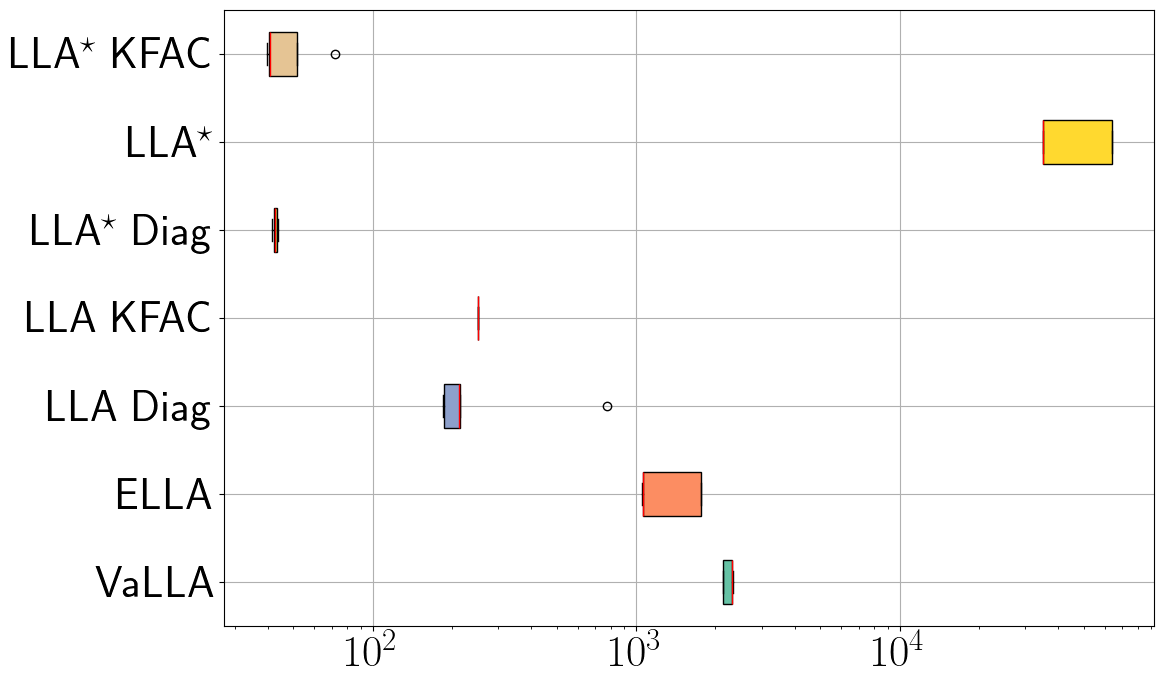

In [26]:
fig, ax = plt.subplots(figsize = (12,8))
b = ax.boxplot([
    times.query("dataset == 'FMNIST' and model == 'VaLLA' and M == 100")["time"].to_numpy()[0],
    times.query("dataset == 'FMNIST' and model == 'ELLA'")["time"].to_numpy()[0],
    times.query("dataset == 'FMNIST' and model == 'LLA' and hessian == 'diag' and subset == 'all'")["time"].to_numpy()[0],
    times.query("dataset == 'FMNIST' and model == 'LLA' and hessian == 'kron' and subset == 'all'")["time"].to_numpy()[0],
    times.query("dataset == 'FMNIST' and model == 'LLA' and hessian == 'diag' and subset == 'last_layer'")["time"].to_numpy()[0],
    times.query("dataset == 'FMNIST' and model == 'LLA' and hessian == 'full' and subset == 'last_layer'")["time"].to_numpy()[0],
    times.query("dataset == 'FMNIST' and model == 'LLA' and hessian == 'kron' and subset == 'last_layer'")["time"].to_numpy()[0],
    ], vert = False, patch_artist=True)

# fill with colors
jet = plt.colormaps["Set2"]
colors = [jet(i) for i in range(8)]
for patch, m, color in zip(b["boxes"], b["medians"], colors):
    patch.set_facecolor(color)
    plt.setp(m, color="red")

ax.set_yticklabels(["VaLLA", "ELLA", r"LLA Diag", r"LLA KFAC", r"LLA$^\star$ Diag", r"LLA$^\star$", r"LLA$^\star$ KFAC"])
plt.grid()
plt.xscale("log")
plt.show()

In [27]:

mpl.rcParams.update(mpl.rcParamsDefault)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = (16, 9)
fontsize = 32
matplotlib.rcParams.update({'font.size': fontsize})
jet = plt.colormaps["Dark2"]
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)


/tmp/ipykernel_11105/2024679875.py:18: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


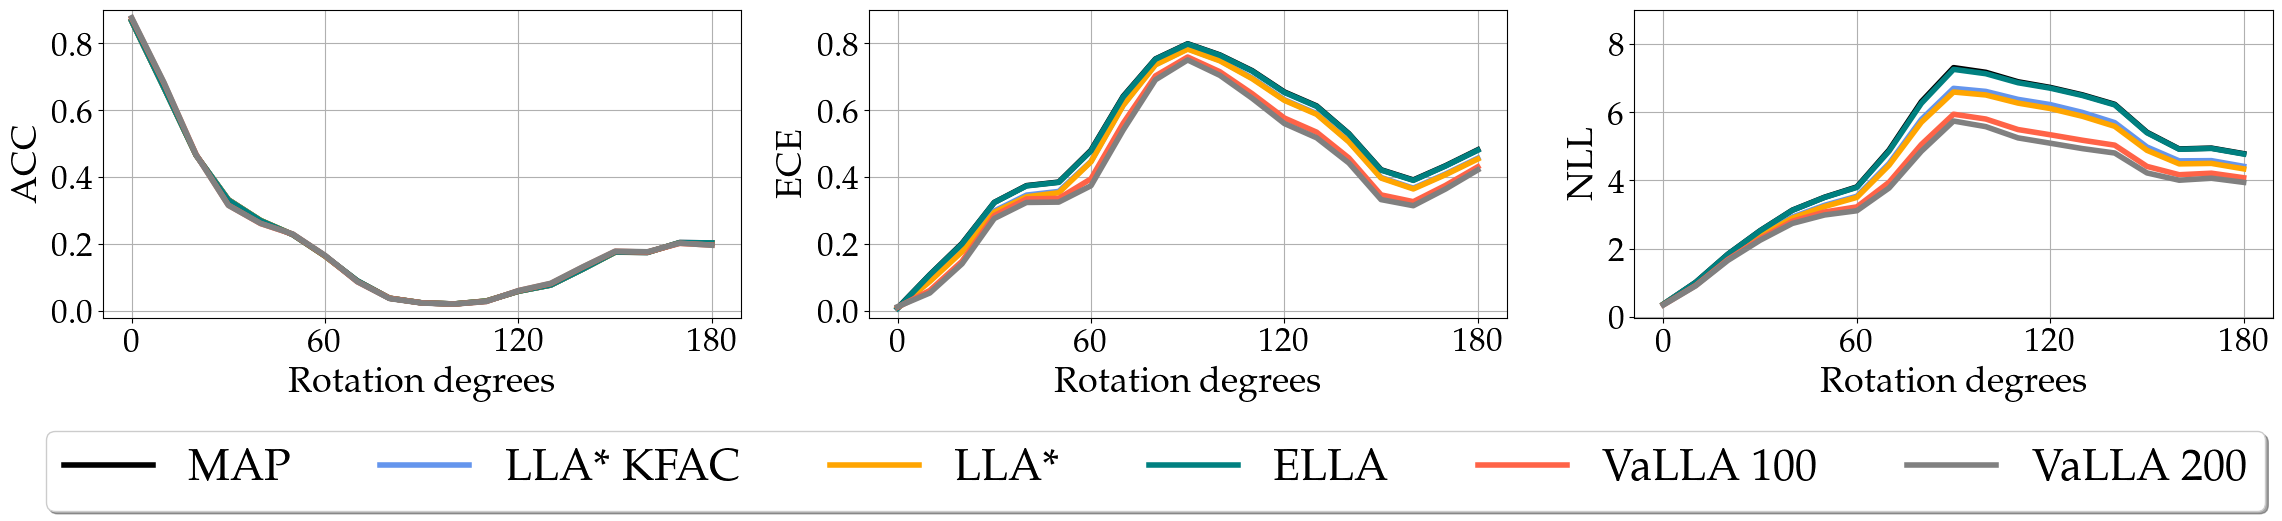

In [28]:

fig, axis = plt.subplots(1, 3, figsize=(28, 4))
plt.subplots_adjust(hspace=1)
colors = ["black", "cornflowerblue", "orange", "teal", "tomato", "gray"]
plot_corruptions("FMNIST", "ACC", range(10, 190, 10), colors, axis[0])
axis[0].set_ylim(-0.02, 0.9)

axis[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8]) 
plot_corruptions("FMNIST", "ECE", range(10, 190, 10), colors, axis[1])
axis[1].set_ylim(-0.02, 0.9)
axis[1].set_yticks([0, 0.2, 0.4, 0.6, 0.8]) 

plot_corruptions("FMNIST", "NLL", range(10, 190, 10), colors, axis[2])
axis[2].set_ylim(-0.02, 9)
axis[2].set_yticks([0, 2, 4, 6, 8]) 

plt.legend(loc='lower center', bbox_to_anchor=(-0.75, -0.7),
          ncol = 6, fancybox=True, shadow=True)
fig.tight_layout()
plt.savefig("Rotations_FMNIST.pdf", format = "pdf", bbox_inches='tight')

plt.show()


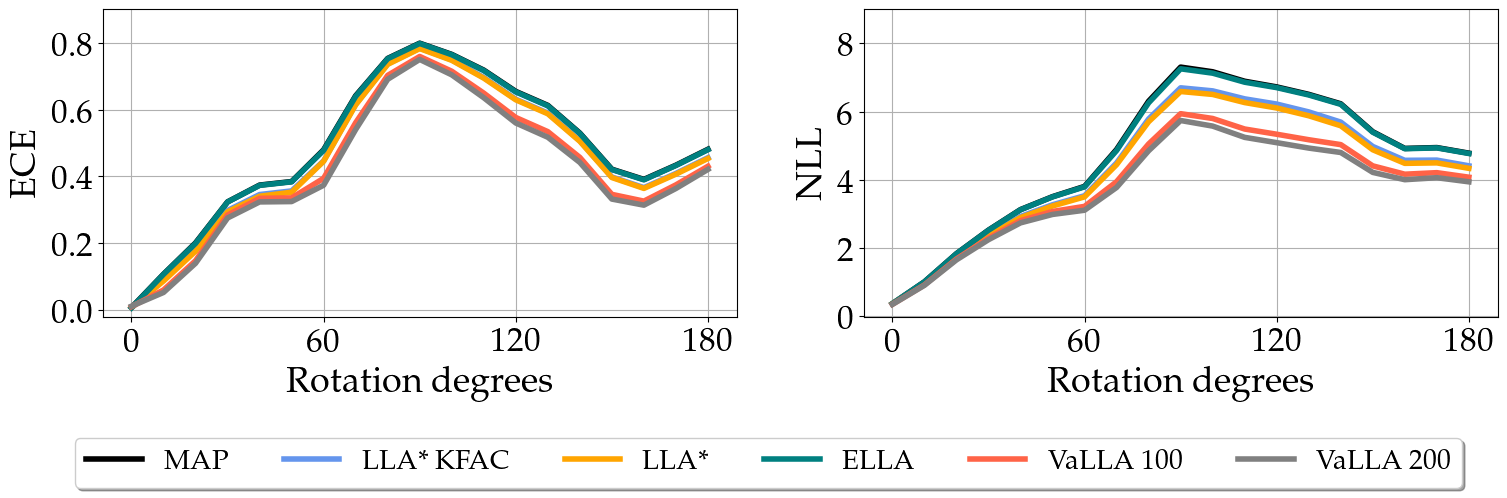

In [29]:

fig, axis = plt.subplots(1, 2, figsize=(18, 4))
plt.subplots_adjust(hspace=1)
colors = ["black", "cornflowerblue", "orange", "teal", "tomato", "gray"]

plot_corruptions("FMNIST", "ECE", range(10, 190, 10), colors, axis[0])
axis[0].set_ylim(-0.02, 0.9)
axis[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8]) 

plot_corruptions("FMNIST", "NLL", range(10, 190, 10), colors, axis[1])
axis[1].set_ylim(-0.02, 9)
axis[1].set_yticks([0, 2, 4, 6, 8]) 

plt.legend(loc='lower center', bbox_to_anchor=(-0.15, -0.6),
          ncol = 6, fancybox=True, shadow=True, fontsize="20")
#fig.tight_layout()
plt.savefig("Rotations_FMNIST.pdf", format = "pdf", bbox_inches='tight')

plt.show()

In [30]:
multiclass.query("dataset == 'FMNIST'")[subset].reset_index().style.background_gradient(axis=0, subset = subset) 

,dataset,model,M,subset,hessian,alpha,ACC,NLL,ECE,BRIER,OOD-AUC,ACC MC,NLL MC,ECE MC,BRIER MC,OOD-AUC MC,prior_std
,,,,,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,FMNIST,ELLA,2000.000000,nan,nan,nan,0.865820,0.373224,0.007620,0.193100,0.873615,0.865980,0.373195,0.008492,0.193089,0.873768,0.840000
1,FMNIST,LLA,nan,all,diag,nan,0.862400,0.397253,0.042987,0.200561,0.913897,0.866100,0.397592,0.061844,0.200690,0.907845,0.091868
2,FMNIST,LLA,nan,all,kron,nan,0.864500,0.376684,0.013903,0.194128,0.932003,0.866600,0.373328,0.017185,0.193048,0.933458,0.183429
3,FMNIST,LLA,nan,last_layer,diag,nan,0.865400,0.374177,0.005766,0.193613,0.878831,0.866000,0.372433,0.006780,0.192868,0.878090,0.146401
4,FMNIST,LLA,nan,last_layer,full,nan,0.865800,0.372896,0.008492,0.192876,0.881700,0.866600,0.374608,0.009477,0.193550,0.878661,0.307297
5,FMNIST,LLA,nan,last_layer,kron,nan,0.865700,0.372808,0.007676,0.192930,0.880454,0.866700,0.374455,0.007160,0.193431,0.877990,0.283915
6,FMNIST,MAP,nan,nan,nan,nan,0.865900,0.373304,0.008545,0.193116,0.873660,0.865900,0.373304,0.008545,0.193116,0.873660,nan
7,FMNIST,VaLLA,100.000000,nan,nan,1.000000,0.873840,0.354741,0.011105,0.182451,0.923029,0.864660,0.378664,0.025760,0.195013,0.914888,0.080570
8,FMNIST,VaLLA,200.000000,nan,nan,1.000000,0.875840,0.351913,0.012598,0.180863,0.933311,0.864720,0.382494,0.032415,0.196193,0.925791,0.101008


In [31]:
multiclass.query("dataset == 'FMNIST'")[subset].reset_index()

,dataset,model,M,subset,hessian,alpha,ACC,NLL,ECE,BRIER,OOD-AUC,ACC MC,NLL MC,ECE MC,BRIER MC,OOD-AUC MC,prior_std
,,,,,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,FMNIST,ELLA,2000.0,NaN,NaN,NaN,0.866,0.373,0.008,0.193,0.874,0.866,0.373,0.008,0.193,0.874,0.840
1,FMNIST,LLA,NaN,all,diag,NaN,0.862,0.397,0.043,0.201,0.914,0.866,0.398,0.062,0.201,0.908,0.092
2,FMNIST,LLA,NaN,all,kron,NaN,0.865,0.377,0.014,0.194,0.932,0.867,0.373,0.017,0.193,0.933,0.183
3,FMNIST,LLA,NaN,last_layer,diag,NaN,0.865,0.374,0.006,0.194,0.879,0.866,0.372,0.007,0.193,0.878,0.146
4,FMNIST,LLA,NaN,last_layer,full,NaN,0.866,0.373,0.008,0.193,0.882,0.867,0.375,0.009,0.194,0.879,0.307
5,FMNIST,LLA,NaN,last_layer,kron,NaN,0.866,0.373,0.008,0.193,0.880,0.867,0.374,0.007,0.193,0.878,0.284
6,FMNIST,MAP,NaN,NaN,NaN,NaN,0.866,0.373,0.009,0.193,0.874,0.866,0.373,0.009,0.193,0.874,NaN
7,FMNIST,VaLLA,100.0,NaN,NaN,1.0,0.874,0.355,0.011,0.182,0.923,0.865,0.379,0.026,0.195,0.915,0.081
8,FMNIST,VaLLA,200.0,NaN,NaN,1.0,0.876,0.352,0.013,0.181,0.933,0.865,0.382,0.032,0.196,0.926,0.101


#### MNIST

In [32]:

res1 = [i for i in glob.glob("../sampled-laplace/results/mlp_mnist_*.csv")]
df = []
for f in res1:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
sampled_mnist = pd.concat(df)


times_sampled_mnist = []
for i in range(5):
    time = np.loadtxt(f"../sampled-laplace/MLP/mlp_mnist/{i}/time.txt")
    time_last = np.loadtxt(f"../sampled-laplace/MLP/mlp_mnist/{i}/last_time.txt")
    times_sampled_mnist.append(time + time_last)

In [33]:
sampled_mnist.mean()

Unnamed: 0        0.000
angle_10/acc      0.956
angle_10/brier    0.072
angle_10/ll      -0.152
angle_10/ece      0.038
                  ...  
OOD AUC           0.954
original/acc      0.976
original/brier    0.040
original/ll      -0.087
original/ece      0.026
Length: 78, dtype: float64

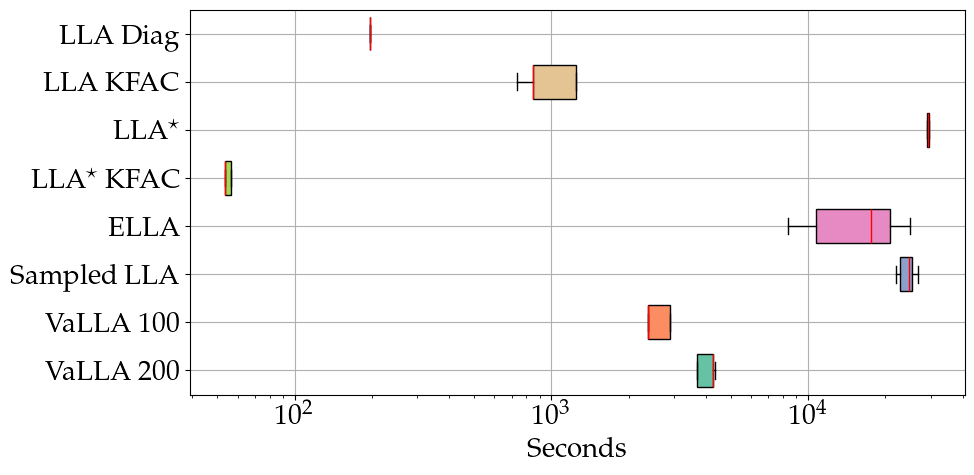

In [54]:
fig, ax = plt.subplots(figsize = (10,5))
b = ax.boxplot([
    times.query("dataset == 'MNIST' and model == 'VaLLA' and M == 200")["time"].to_numpy()[0],
    times.query("dataset == 'MNIST' and model == 'VaLLA' and M == 100")["time"].to_numpy()[0],
    times_sampled_mnist,
    10 * times.query("dataset == 'MNIST' and model == 'ELLA'")["time"].to_numpy()[0],    
    times.query("dataset == 'MNIST' and model == 'LLA' and hessian == 'kron' and subset == 'last_layer'")["time"].to_numpy()[0],
    times.query("dataset == 'MNIST' and model == 'LLA' and hessian == 'full' and subset == 'last_layer'")["time"].to_numpy()[0],
    times.query("dataset == 'MNIST' and model == 'LLA' and hessian == 'kron' and subset == 'all'")["time"].to_numpy()[0],
    times.query("dataset == 'MNIST' and model == 'LLA' and hessian == 'diag' and subset == 'all'")["time"].to_numpy()[0],
    ], vert = False, patch_artist=True, showfliers=False, widths = 0.7)

# fill with colors
jet = plt.colormaps["Set2"]
colors = [jet(i) for i in range(8)]
for patch, m, color in zip(b["boxes"], b["medians"], colors):
    patch.set_facecolor(color)
    plt.setp(m, color="red")

ax.set_yticklabels(["VaLLA 200", "VaLLA 100", "Sampled LLA", "ELLA", r"LLA$^\star$ KFAC", 
                     r"LLA$^\star$",   r"LLA KFAC", r"LLA Diag"])
plt.xlabel("Seconds", fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid()
plt.xscale("log")
plt.savefig("times_mnist.pdf", format = "pdf", bbox_inches='tight')
plt.show()

/tmp/ipykernel_11105/760150569.py:8: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


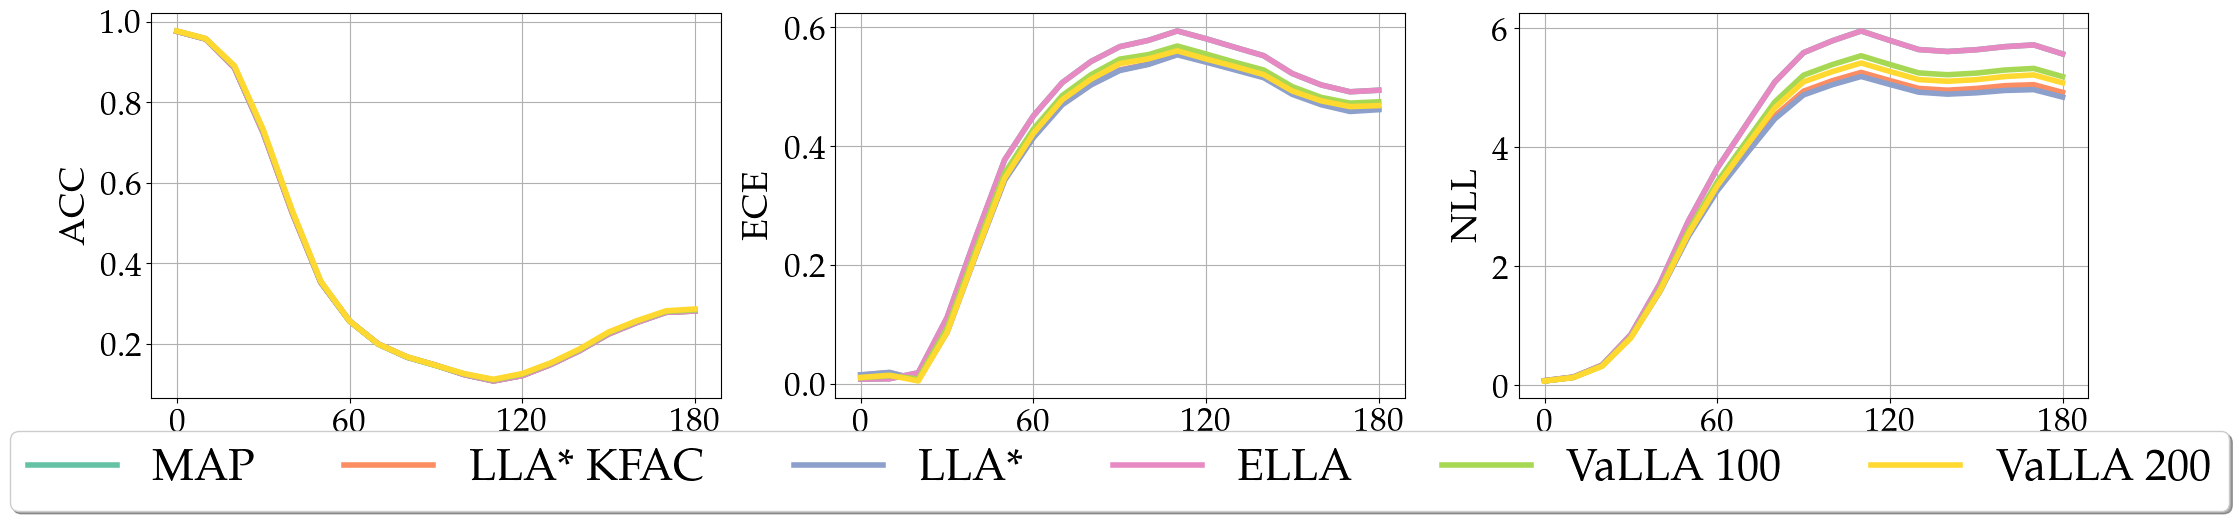

In [35]:
fig, axis = plt.subplots(1, 3, figsize=(25, 5))
plot_corruptions("MNIST", "ACC", range(10, 190, 10), colors, axis[0])
plot_corruptions("MNIST", "ECE", range(10, 190, 10), colors, axis[1])
plot_corruptions("MNIST", "NLL", range(10, 190, 10), colors, axis[2])

plt.legend(loc='lower center', bbox_to_anchor=(-0.7, -0.35),
          ncol = 6, fancybox=True, shadow=True)
fig.tight_layout()
plt.savefig("Rotations_MNIST.pdf", format = "pdf", bbox_inches='tight')

plt.show()

In [36]:
multiclass.query("dataset == 'MNIST'")[subset].reset_index().style.background_gradient(axis=0, subset = subset) 

,dataset,model,M,subset,hessian,alpha,ACC,NLL,ECE,BRIER,OOD-AUC,ACC MC,NLL MC,ECE MC,BRIER MC,OOD-AUC MC,prior_std
,,,,,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,MNIST,ELLA,2000.000000,nan,nan,nan,0.975900,0.075854,0.008007,0.036465,0.904709,0.975900,0.075852,0.008126,0.036464,0.904715,0.001000
1,MNIST,LLA,nan,all,diag,nan,0.973600,0.143026,0.071633,0.053298,0.922130,0.975800,0.159261,0.092591,0.057486,0.936246,0.109102
2,MNIST,LLA,nan,all,kron,nan,0.975000,0.094496,0.028624,0.040597,0.948832,0.975900,0.097798,0.035898,0.041459,0.959331,0.186259
3,MNIST,LLA,nan,last_layer,diag,nan,0.975700,0.079959,0.012636,0.037293,0.904021,0.975900,0.079127,0.012928,0.036977,0.908116,0.189619
4,MNIST,LLA,nan,last_layer,full,nan,0.975900,0.081351,0.015174,0.037130,0.909428,0.975900,0.080326,0.013850,0.037133,0.901206,0.383684
5,MNIST,LLA,nan,last_layer,kron,nan,0.975800,0.081111,0.014737,0.037156,0.908721,0.975900,0.079103,0.012122,0.036967,0.904021,0.365268
6,MNIST,MAP,nan,nan,nan,nan,0.975900,0.075852,0.007844,0.036465,0.904711,0.975900,0.075852,0.007844,0.036465,0.904711,nan
7,MNIST,VaLLA,100.000000,nan,nan,1.000000,0.976600,0.075735,0.010272,0.035735,0.916036,0.976000,0.078313,0.011892,0.036877,0.913689,0.033428
8,MNIST,VaLLA,200.000000,nan,nan,1.000000,0.976920,0.075215,0.010764,0.035283,0.920793,0.976000,0.079360,0.013540,0.037093,0.917433,0.041004


In [37]:
multiclass.query("dataset == 'MNIST'")[subset].reset_index()

,dataset,model,M,subset,hessian,alpha,ACC,NLL,ECE,BRIER,OOD-AUC,ACC MC,NLL MC,ECE MC,BRIER MC,OOD-AUC MC,prior_std
,,,,,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,MNIST,ELLA,2000.0,NaN,NaN,NaN,0.976,0.076,0.008,0.036,0.905,0.976,0.076,0.008,0.036,0.905,0.001
1,MNIST,LLA,NaN,all,diag,NaN,0.974,0.143,0.072,0.053,0.922,0.976,0.159,0.093,0.057,0.936,0.109
2,MNIST,LLA,NaN,all,kron,NaN,0.975,0.094,0.029,0.041,0.949,0.976,0.098,0.036,0.041,0.959,0.186
3,MNIST,LLA,NaN,last_layer,diag,NaN,0.976,0.080,0.013,0.037,0.904,0.976,0.079,0.013,0.037,0.908,0.190
4,MNIST,LLA,NaN,last_layer,full,NaN,0.976,0.081,0.015,0.037,0.909,0.976,0.080,0.014,0.037,0.901,0.384
5,MNIST,LLA,NaN,last_layer,kron,NaN,0.976,0.081,0.015,0.037,0.909,0.976,0.079,0.012,0.037,0.904,0.365
6,MNIST,MAP,NaN,NaN,NaN,NaN,0.976,0.076,0.008,0.036,0.905,0.976,0.076,0.008,0.036,0.905,NaN
7,MNIST,VaLLA,100.0,NaN,NaN,1.0,0.977,0.076,0.010,0.036,0.916,0.976,0.078,0.012,0.037,0.914,0.033
8,MNIST,VaLLA,200.0,NaN,NaN,1.0,0.977,0.075,0.011,0.035,0.921,0.976,0.079,0.014,0.037,0.917,0.041


# Resnet

In [38]:

resnet20 = [i for i in glob.glob("results/VaLLA_resnet20*")]
df = []
for f in resnet20:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
resnet20 =pd.concat(df)
resnet32 = [i for i in glob.glob("results/VaLLA_resnet32*")]
df = []
for f in resnet32:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
resnet32 =pd.concat(df)
resnet44 = [i for i in glob.glob("results/VaLLA_resnet44*")]
df = []
for f in resnet44:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
resnet44 =pd.concat(df)
resnet56 = [i for i in glob.glob("results/VaLLA_resnet56*")]
df = []
for f in resnet56:
    try:
        df.append(pd.read_csv(f))
    except:
        continue
resnet56 =pd.concat(df)

In [39]:
resnet20["model"] = "Resnet20"
resnet32["model"] = "Resnet32"
resnet44["model"] = "Resnet44"
resnet56["model"] = "Resnet56"

In [40]:
resnet20.columns

Index(['Unnamed: 0', 'LOSS', 'NLL', 'ACC', 'ECE', 'BRIER', 'NLL MC', 'ACC MC',
       'ECE MC', 'BRIER MC',
       ...
       'LOSS-C-18-4', 'NLL-C-18-4', 'ACC-C-18-4', 'ECE-C-18-4', 'BRIER-C-18-4',
       'NLL MC-C-18-4', 'ACC MC-C-18-4', 'ECE MC-C-18-4', 'BRIER MC-C-18-4',
       'model'],
      dtype='object', length=877)

In [41]:

df = pd.concat([resnet20, resnet32, resnet44, resnet56]).drop(
    ["LOSS", "Unnamed: 0", "iterations", "weight_decay", "MAP_iterations", "timer"], axis=1
).query("M == 100")

In [42]:
df[["model", "M", "ACC", "NLL", "ECE", "BRIER",  "ACC MC", "NLL MC", "ECE MC", "BRIER MC"]].groupby(["model", "M"]).mean()

,,ACC,NLL,ECE,BRIER,ACC MC,NLL MC,ECE MC,BRIER MC
model,M,,,,,,,,
Resnet20,100,0.924,0.231,0.005,0.113,0.926,0.228,0.007,0.110
Resnet32,100,0.932,0.212,0.009,0.100,0.935,0.211,0.007,0.098
Resnet44,100,0.938,0.201,0.012,0.094,0.940,0.198,0.008,0.092
Resnet56,100,0.942,0.186,0.011,0.086,0.944,0.183,0.009,0.084


In [43]:
metric = "ECE"
models = df["model"].to_numpy()
res = []
for i in range(5):
    aux = []
    for j in range(19):
        key = "-".join([metric, "C", str(j), str(i)])
        aux.append(df[key].to_numpy())
    res.append(aux)
res = np.array(res)
print(res.shape)

(5, 19, 20)


In [44]:
res2 = []

for k in range(len(models)):
    for i in range(5):
        for j in range(19):
            for l in range(6):
                res2.append([l, models[k], i+1, res[i, j, k]])
res2 = np.array(res2)
res2 = pd.DataFrame(res2, columns = ["Replicate", "Model", "Corruption","Value"])
res2["Corruption"] = pd.to_numeric(res2["Corruption"])
res2["Value"] = pd.to_numeric(res2["Value"])
res2["Replicate"] = pd.to_numeric(res2["Replicate"])

res2

,Replicate,Model,Corruption,Value
0,0,Resnet20,1,0.043
1,1,Resnet20,1,0.043
2,2,Resnet20,1,0.043
3,3,Resnet20,1,0.043
4,4,Resnet20,1,0.043
...,...,...,...,...
11395,1,Resnet56,5,0.461
11396,2,Resnet56,5,0.461
11397,3,Resnet56,5,0.461
11398,4,Resnet56,5,0.461


In [45]:
import seaborn as sns

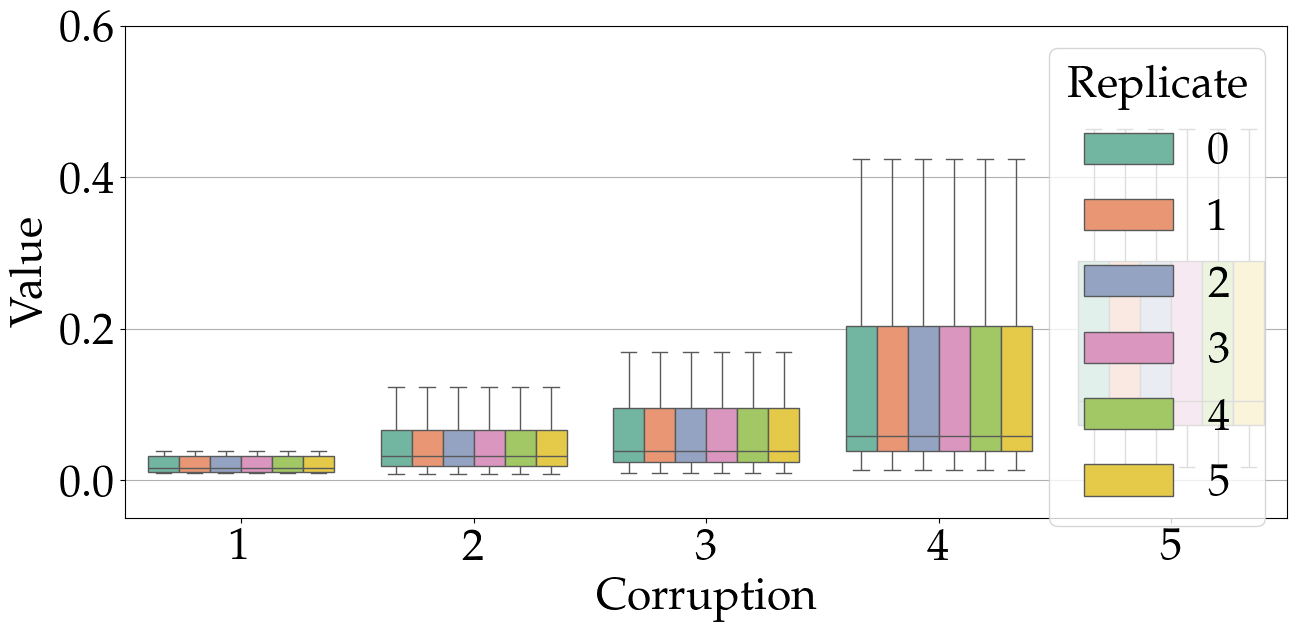

In [46]:
fig, axis = plt.subplots(1, 1, figsize=(15, 6.4))
sns.boxplot(res2.query("Model == 'Resnet56'"), x = "Corruption", y = "Value", hue = "Replicate", palette = "Set2", fliersize = 0, ax = axis),
axis.set_ylim([-0.05, 0.6])  
axis.grid(axis = "y")
plt.savefig("boxplot.pdf")
plt.show()
